# Detecting Anomalies

The purpose of this notebook is to detect abnormalities within a tensorboard scalar.

In [1]:
import re
import sys
import random

# Setup the "PYTHONPATH"
sys.path.insert(0, '../')

In [2]:
import math

from src.utils import ExponentiallyWeightedMovingAverage

def get_running_mean_and_standard_deviation(steps, values, beta=0.9, sigma=8):
    """ Compute exponentially weighted running mean and standard deviation.
    
    Args:
        steps (list of float): Step at which each value occured.
        values (list of float): Values at each step.
        beta (float): Beta used to weight the exponential mean and standard deviation.
        sigma (float): Number of standard deviations before ignoring an abnormality.
        
    Returns:
        means (list of float): Exponentially weighted running means for each step.
        standard_deviations (list of float): Exponentially weighted running standard deviation for each step.
    """
    assert len(values) == len(steps)
    
    stats = ExponentiallyWeightedMovingAverage()
    means, standard_deviations = [], []
    average, variance = 0.0, 0.0
    last_abnormality = 0
    eps = 10**-6
    for i, (step, value) in enumerate(zip(steps, values)):
        # Detected abnormality
        # NOTE: ``i < 1`` then ``variance == 0.0``
        # NOTE: Above a sample size 10, we do not need to consider sample variance bias correction
        if i > 10 and abs(value - means[-1]) > standard_deviations[-1] * sigma + eps:
            if i > last_abnormality + 100:
                print('Detected abnormality (%f > %f ± %f), at index %d or step %d (step ignored)' %
                      (value, means[-1], standard_deviations[-1] * sigma, i, step))
            last_abnormality = i
            means.append(means[-1])
            standard_deviations.append(standard_deviations[-1])
        else:
            average, standard_deviation = stats.step(value)
            means.append(average)
            standard_deviations.append(standard_deviation)
    return means, standard_deviations

def plot_abnormality(steps, values, means, standard_deviations, sigma=8):
    """ Plot values at steps with a running mean and standard deviation.
    
    Args:
        step (list of float): Step at which each value occured.
        value (list of float): Values at each step.
        means (list of float): Exponentially weighted running means for each step.
        standard_deviations (list of float): Exponentially weighted running standard deviation for each step.
        sigma (float): Number of standard deviations before ignoring an abnormality.      
    """
    pyplot.figure(figsize=(20, 10))
    pyplot.style.use('ggplot')
    kwargs = {
        'marker': '.',
        'linestyle': 'solid'
    }
    pyplot.plot(steps, values, label='Value', **kwargs)
    pyplot.plot(steps, means, label='Mean', **kwargs)
    
    upper_bound = [value + sigma * sd for value, sd in zip(means, standard_deviations)]
    lower_bound = [value - sigma * sd for value, sd in zip(means, standard_deviations)]

    pyplot.plot(steps, upper_bound, label='Upper Bound', **kwargs)
    pyplot.plot(steps, lower_bound, label='Lower Bound', **kwargs)
    
    pyplot.legend()
    pyplot.ylabel('Value')
    pyplot.xlabel('Step')

In [3]:
def load_tensorboard_data(path):
    """ Load a CSV file with 3 columns: wall_time, step, value
    
    Args:
        path (str): Path to the CSV file.
    """
    data = [row for row in open(path, 'r')]
    print('Header:', data[0].strip())
    data = [tuple([float(val) for val in row.strip().split(',')]) for row in data[1:]]
    print('Sample:', data[:5])
    _, step, value = zip(*data)
    return step, value

In [20]:
print('\nLoading coarse step data...')
coarse_loss = {}
coarse_loss['step'], coarse_loss['value'] = load_tensorboard_data(
    '/tmp/csv_output/data_tb___coarse_loss_step.csv')


Loading coarse step data...
Header: wall_time,step,value
Sample: [(1533364077.3112936, 138.0, 5.575411319732666), (1533364130.131939, 141.0, 5.285267353057861), (1533364130.4684741, 145.0, 4.917966365814209), (1533364130.7894676, 148.0, 4.351244926452637), (1533364131.1123998, 151.0, 3.925124168395996)]


In [21]:
%matplotlib inline

from matplotlib import pyplot

sigma = 6

In [22]:
coarse_loss['mean'], coarse_loss['standard_deviation'] = get_running_mean_and_standard_deviation(
    coarse_loss['step'], coarse_loss['value'], sigma=4.5, beta=0.99)

30743 30753


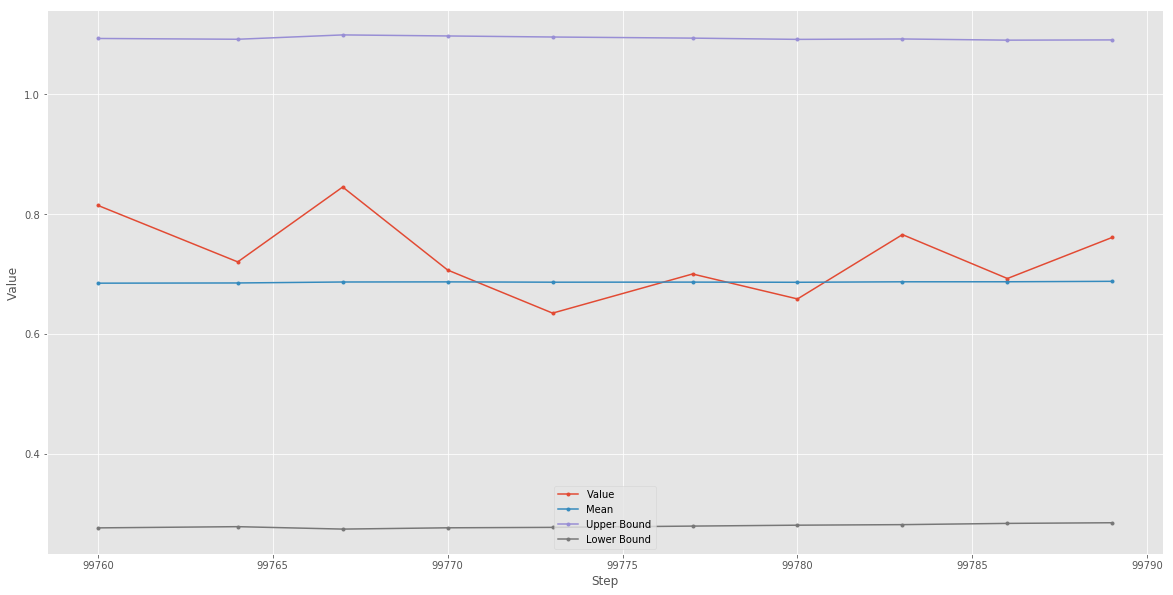

In [23]:
start = len(coarse_loss['step']) - 10
end = len(coarse_loss['step'])
print(start, end)
plot_abnormality(coarse_loss['step'][start:end],
                 coarse_loss['value'][start:end],
                 coarse_loss['mean'][start:end],
                 coarse_loss['standard_deviation'][start:end],
                 sigma=5)